# Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from scipy.sparse import csr_matrix, find
from matplotlib import pyplot as plt
import os

## **Phân tích bộ dữ liệu MovieLens 100K**

Bộ dữ liệu MovieLens 100K được thiết kế cho các nghiên cứu liên quan đến **hệ thống gợi ý** (Recommendation Systems). Dưới đây là mô tả chi tiết về cấu trúc, thống kê và ứng dụng.

---

### **1. Cấu trúc các tệp dữ liệu**
#### **a. Tệp `u.data`**
- **Mục đích**: Chứa các đánh giá của người dùng đối với các bộ phim.
- **Cấu trúc**: user id | item id | rating | timestamp
- **user id**: ID của người dùng (1 - 943).
- **item id**: ID của phim (1 - 1682).
- **rating**: Điểm đánh giá của người dùng, từ 1 đến 5.
- **timestamp**: Dấu thời gian khi đánh giá được tạo ra (theo Unix time).

#### **b. Tệp `u.item`**
- **Mục đích**: Cung cấp thông tin chi tiết về từng bộ phim.
- **Cấu trúc**: movie id | movie title | release date | video release date | IMDb URL | genres
- **movie id**: ID của phim (trùng với `item id` trong `u.data`).
- **movie title**: Tên của bộ phim.
- **release date**: Ngày phát hành.
- **video release date**: Ngày phát hành phiên bản video (nếu có).
- **IMDb URL**: Đường dẫn đến trang IMDb của bộ phim.
- **genres**: Mảng nhị phân gồm 19 thể loại (Action, Adventure, Animation, Comedy, Drama, Horror,...).

#### **c. Tệp `u.user`**
- **Mục đích**: Cung cấp thông tin nhân khẩu học của người dùng.
- **Cấu trúc**: user id | age | gender | occupation | zip code
- **user id**: ID của người dùng (trùng với `user id` trong `u.data`).
- **age**: Tuổi của người dùng.
- **gender**: Giới tính của người dùng (M hoặc F).
- **occupation**: Nghề nghiệp của người dùng (ví dụ: kỹ sư, sinh viên...).
- **zip code**: Mã bưu điện nơi cư trú.


## **2. Thống kê chính**
- **Số lượng đánh giá**: 100.000 đánh giá.
- **Số người dùng**: 943 người dùng.
- **Số bộ phim**: 1.682 bộ phim.
- **Số thể loại phim**: 19 thể loại (có thể đồng thời thuộc nhiều thể loại).

### **3. Ứng dụng thực tiễn**
#### **a. Xây dựng hệ thống gợi ý**
- **Collaborative Filtering**:
- Gợi ý phim dựa trên sở thích của những người dùng có hành vi tương tự.
- Content-Based Filtering:
- Gợi ý dựa trên thông tin nội dung phim như thể loại, ngày phát hành.

#### **b. Phân tích hành vi người dùng**
- Phân tích xu hướng đánh giá phim theo tuổi, giới tính, hoặc nghề nghiệp.
- Ví dụ: Nam giới trong độ tuổi 18-25 có xu hướng thích thể loại hành động hơn.




# Load Dataset

In [ ]:
train_data_path = "/content/drive/MyDrive/MDEK/Group2/Endterm/ub.base"
test_data_path = "/content/drive/MyDrive/MDEK/Group2/Endterm/ub.test"

print(f"Does training data exist? {os.path.exists(train_data_path)}")
print(f"Does test data exist? {os.path.exists(test_data_path)}")

Does training data exist? True
Does test data exist? True


## Train data

In [ ]:
cols = ["user_id", "item_id", "rating", "unix_timestamp"]
df = pd.read_csv(train_data_path, sep="\t", names=cols)

In [ ]:
df.head()

,user_id,item_id,rating,unix_timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [ ]:
# Only use user_id, item_id, rating
# Drop unix_timestamp
train_df = df.drop("unix_timestamp", axis=1)

In [ ]:
train_df.head()

,user_id,item_id,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


In [ ]:
# Information on train data

n_users = train_df["user_id"].nunique()
n_items = train_df["item_id"].nunique()

print(f"Number of users: {n_users}")
print(f"Number of items: {n_items}")

max_user_id = train_df["user_id"].max()
max_item_id = train_df["item_id"].max()

# Note that the user/item indices in this dataset isn't
# in range [0, n_users/n_items]
print(f"Max user id: {max_user_id}")
print(f"Max item id: {max_item_id}")

Number of users: 943
Number of items: 1675
Max user id: 943
Max item id: 1682


### Create User-Item Compressed Sparse Row (CSR) Matrix

In [ ]:
# The csr_matrix only accepts the index that begins at 0, not 1

tmp_df = train_df.copy()
tmp_df["user_id"] = train_df["user_id"] - 1
tmp_df["item_id"] = train_df["item_id"] - 1

In [ ]:
tmp_df.head()

,user_id,item_id,rating
0,0,0,5
1,0,1,3
2,0,2,4
3,0,3,3
4,0,4,3


In [ ]:
# Utility Matrix: rows are users and columns are items (moives)
# Note that use max_user_id and max_item_id to create CSR matrix
# Because number of users and number of Items could be less than max index
train_user_item_matrix = csr_matrix(
            (df["rating"], (df["user_id"] - 1, df["item_id"] - 1)),
            shape=(max_user_id + 1, max_item_id + 1), dtype=np.float64)

In [ ]:
print(train_user_item_matrix[0])

  (0, 0)	5.0
  (0, 1)	3.0
  (0, 2)	4.0
  (0, 3)	3.0
  (0, 4)	3.0
  (0, 5)	5.0
  (0, 6)	4.0
  (0, 7)	1.0
  (0, 8)	5.0
  (0, 9)	3.0
  (0, 10)	2.0
  (0, 11)	5.0
  (0, 12)	5.0
  (0, 13)	5.0
  (0, 14)	5.0
  (0, 15)	5.0
  (0, 17)	4.0
  (0, 18)	5.0
  (0, 19)	4.0
  (0, 20)	1.0
  (0, 21)	4.0
  (0, 22)	4.0
  (0, 23)	3.0
  (0, 24)	4.0
  (0, 25)	3.0
  :	:
  (0, 246)	1.0
  (0, 247)	4.0
  (0, 248)	4.0
  (0, 249)	4.0
  (0, 250)	4.0
  (0, 251)	2.0
  (0, 253)	1.0
  (0, 254)	2.0
  (0, 255)	4.0
  (0, 256)	4.0
  (0, 257)	5.0
  (0, 258)	1.0
  (0, 259)	1.0
  (0, 260)	1.0
  (0, 261)	3.0
  (0, 262)	1.0
  (0, 263)	2.0
  (0, 264)	4.0
  (0, 265)	1.0
  (0, 266)	4.0
  (0, 267)	5.0
  (0, 268)	5.0
  (0, 269)	5.0
  (0, 270)	2.0
  (0, 271)	3.0


In [ ]:
print(f"""The Row 0 (User 0) in created Utility Matrix:
        {train_user_item_matrix[0].toarray()}""")

The Row 0 (User 0) in created Utility Matrix:
        [[5. 3. 4. ... 0. 0. 0.]]


In [ ]:
# Let's see User 0 rated which Items
rated_indices = train_user_item_matrix[0].indices
print(rated_indices)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  90  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 222
 223 224 225 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 253 254 255 25

## Test data

In [ ]:
test_df = pd.read_csv(test_data_path, sep="\t", names=cols)

test_df.drop("unix_timestamp", axis=1, inplace=True)

test_user_item_matrix = csr_matrix(
                (test_df["rating"], \
                (test_df["user_id"] - 1, test_df["item_id"] - 1)),
                shape=(test_df["user_id"].max() + 1,
                       test_df["item_id"].max() + 1), dtype=np.float64)

# Neigborhood-Based Collaborative Filtering (NBCF)

## NBCF Class

In [ ]:
class NBCF():
    def __init__(self, k, dist_func=cosine_similarity, uuCF=1):
        self.uuCF = uuCF # user-user (1) or item-item (0) CF
        self.data = None
        self.n_users = 0
        self.n_items = 0
        self.k = k # number of neighbor points
        self.dist_func = dist_func

        self.normalized_data = None
        self.means = list()
        self.S = None

    def _similarity(self):
        self.S = self.dist_func(self.normalized_data)

    def _normalize(self):
        matrix = self.data.copy()
        for user_i in range(self.n_users):
            denominator = matrix[user_i, :].nnz
            avg = 0
            if  denominator != 0:
                avg = matrix[user_i, :].data.sum() / denominator
                matrix.data[matrix.indptr[user_i]:matrix.indptr[user_i + 1]] -= avg

            self.means.append(avg)

        self.normalized_data = matrix

    def fit(self, csr_matrix):
        self.data = csr_matrix if self.uuCF else csr_matrix.T

        # number of users and items
        self.n_users = self.data.shape[0] if self.uuCF else self.data.shape[1]
        self.n_items = self.data.shape[1] if self.uuCF else self.data.shape[0]

        self._normalize()
        self._similarity()


    def _pred(self, user_id, item_id):
        """
        predict the rating of user u for item i (normalized)
        """
        # Step 1: Find users who rated items i
        # user (row) item (col) --> item (row) user (col)
        # in row i-th, get all non-zero indices (users - cols)
        users_rated_item_id = self.data.T.tocsr()[item_id].indices

        # Step 2: find similarity btw the current user and others
        # who already rated i
        sim = self.S[user_id, users_rated_item_id]

        # Step 3: find the k most similarity users
        nearest_user = np.argsort(sim)[-self.k:]
        nearest_sim = sim[nearest_user]

        # Get ratings and calculate weighted average
        nearest_ratings = self.normalized_data[nearest_user, item_id].toarray()
        numerator = np.sum(nearest_sim * nearest_ratings)
        denominator = np.sum(np.abs(nearest_sim)) + 1e-8

        predicted_rating = numerator/denominator
        final_rating = self.means[user_id] + predicted_rating

        return np.clip(final_rating, 0, 5)


    def recommend(self, user_id, n_recom=10):
        """
        Determine all items should be recommended for user u. (uuCF =1)
        or all users who might have interest on item u (uuCF = 0)
        The decision is made based on all i such that:
        self.pred(u, i) > 0. Suppose we are considering items which
        have not been rated by u yet.
        """

        user_id = int(user_id)

        items_rated_by_u = self.data[user_id].indices

        unrated_predictions = []

        for item_id in range(self.n_items):
            if item_id not in items_rated_by_u:
                prediction = self._pred(user_id, item_id)
                unrated_predictions.append({
                    "item_id": item_id,
                    "prediction": prediction
                })

         # Sort predictions in descending order and return top N
        df = pd.DataFrame(unrated_predictions)
        df = (df.sort_values('prediction', ascending=False)
                .head(n_recom)
                .reset_index(drop=True))

        return df


    def evaluate(self, test_data):
        test_data = test_data if self.uuCF else test_data.T.tocsr()

        users, items, ground_truth = find(test_data)

        predicted_list = []

        square_error = 0

        for i in range(len(users)):
            predicted = self._pred(users[i], items[i])
            predicted_list.append(predicted)
            square_error += (ground_truth[i] - predicted) ** 2


        df = pd.DataFrame(
                {
                "user_id": users,
                "item_id": items,
                "ground_truth": ground_truth,
                "prediction": predicted_list
                })

        if(self.uuCF == 0):
            df = pd.DataFrame(
                {
                "item_id": users,
                "user_id": items,
                "ground_truth": ground_truth,
                "prediction": predicted_list
                })

        return df, np.sqrt(square_error / len(users))

## Create NBCF Instance and Fit

In [ ]:
# uuCF = 1 : users-users
# uuCF = 0 : items-items
# When choosing uuCF user-item CSR matrix transpose to item-user CSR matrix

nbcf = NBCF(k=10, uuCF=1)
nbcf.fit(train_user_item_matrix)

## Recommendation - Unrated Items Prediction

In [ ]:
user_id = 511
n_recom = 10
recommend_list = nbcf.recommend(user_id, n_recom)

In [ ]:
print(f"User_id: {user_id}")
recommend_list.head(10)

User_id: 511


,item_id,prediction
0,633,5.0
1,226,5.0
2,237,5.0
3,527,5.0
4,528,5.0
5,233,5.0
6,529,5.0
7,227,5.0
8,225,5.0
9,208,5.0


## Evaluation in Testset

In [ ]:
eval_NBCF_df, rmse_NBCF = nbcf.evaluate(test_user_item_matrix)

In [ ]:
print(f"RMSE: {rmse_NBCF}")
eval_NBCF_df.head()

RMSE: 1.4524922739631903


,user_id,item_id,ground_truth,prediction
0,0,16,3.0,3.587786
1,0,46,4.0,3.602824
2,0,63,5.0,2.154693
3,0,89,4.0,1.935304
4,0,91,3.0,4.766803


# Alternating Least Squares (ALS)

##  ALS class

In [ ]:
class ALS:
    def __init__(self, n_factors=5, lambda_reg=1e-8, epsilon=1e-8, max_iter=20,
                print_loss=False):
        self.print_loss = print_loss
        self.K = n_factors # Number of factors, K
        self.lambda_reg = lambda_reg # regularization
        self.epsilon = epsilon # Just for early stopping
        self.X = None # User-to-concept Matrix
        self.W = None # Item-to-concept Matrix
        self.N = 0 # Number of Users
        self.M = 0 # Number of Items
        self.Y = None # Utility Matrix
        self.normalized_Y = None # Normalized Utility Matrix
        self.Y_hat = None # Approximate (Estimated) Y
        self.max_iter = max_iter # Maximum iteration
        self.losses = [] # Storage for losses
        self.means = None # Storage for averages, means, just in normalization

    def _normalize(self):
        matrix = self.Y.copy()
        means = []
        for user_i in range(self.N):
            denominator = matrix[user_i, :].nnz
            avg = 0
            if  denominator != 0:
                avg = matrix[user_i, :].data.sum() / denominator
                matrix.data[matrix.indptr[user_i]:matrix.indptr[user_i + 1]] -= avg

            means.append(avg)

        self.normalized_Y = matrix
        self.means = np.array(means)

    def _loss(self):
        return (
            1/(2 * self.normalized_Y.shape[0])
            * np.linalg.norm((self.normalized_Y - self.X @ self.W), "fro")\
           + self.lambda_reg * (np.linalg.norm(self.X, "fro")
                                + np.linalg.norm(self.W, "fro")))

    def _update_X(self):
        for user_i in range(self.N):
            # Item indices were rated user_i, (M', )
            rated_ids = self.normalized_Y[user_i,:].indices

            # M', Number of items were rated user_i
            M_ = rated_ids.shape[0]

            # Check if rated_ids is empty
            if rated_ids.size == 0:
                # If empty, skip this user and continue to the next one
                continue

            y_hat_i = self.normalized_Y[user_i, :].data.reshape(1, -1) # (1xN')
            W_hat_i = self.W[:, rated_ids] # (KxN')

            A =  y_hat_i @ W_hat_i.T # (1xN') x (N'xK) = (1xK)

            B = W_hat_i @ W_hat_i.T # (KxN') x (N'xK) = (KxK)

            C = M_ * self.lambda_reg * np.identity(self.K)  # M' x lambda x (KxK)

            # (1xK) x (KxK) = (1xK)
            self.X[user_i,:] = A @ np.linalg.inv(B + C)

    def _update_W(self):
        for item_j in range(self.M):
            # User indices whose rated item_j, (M', )
            rated_ids = self.normalized_Y[:,item_j].indices

            # Number of user whose rated by item_j
            M_ = rated_ids.shape[0]

            if rated_ids.size == 0:
                continue

            X_hat_j = self.X[rated_ids, :] # (M'xK)
            y_hat_j = self.normalized_Y[:, item_j].data.reshape(-1, 1) # (M'x1)

            A = X_hat_j.T @ y_hat_j # (KxM') x (M'x1) = (Kx1)

            B = X_hat_j.T @ X_hat_j # (KxM') x (M'xK) = (KxK)

            C = M_ * self.lambda_reg * np.identity(self.K) # M'x lambda x (KxK)

            # (KxK) x (Kx1) = (Kx1)
            # Before reshape: (K, 1) - After: (K, ) bc. update column in W
            self.W[:, item_j] = (np.linalg.inv(B + C) @ A).reshape(-1)


    def fit(self, csr_matrix):
        self.Y = csr_matrix.copy()
        self.Y_hat = self.Y.copy()
        self.N = self.Y.shape[0] # Number of users, row dimension
        self.M = self.Y.shape[1] # Number of items, column dimension
        self.X = np.random.normal(0, 0.01, (self.N, self.K)) # shape: (MxK)
        self.W = np.random.normal(0, 0.01, (self.K, self.M)) # (KxN)

        self._normalize()

        loss_old = self._loss()

        for i in range(self.max_iter):

            self._update_X()
            self._update_W()

            loss_new = self._loss()

            if self.print_loss: print(f"Iter: {i} Loss: {loss_new} " +
                f"|loss_new - loss_old|: {np.abs(loss_new - loss_old)}")

            """
            Early Stopping:
            if |loss_new - loss_old| >= self.epsilon -> step
            or if loss_new >= 2-step-back loss_old -> step
            """
            if (np.abs(loss_new - loss_old) < self.epsilon
                or (i >= 3 and loss_new > self.losses[i - 3])):
                if self.print_loss: print("Converged!")
                break

            self.losses.append(loss_new)
            loss_old = loss_new

        self.Y_hat = self._transform(self.X @ self.W)

    def _transform(self, matrix):
        for user_i in range(self.N):
            matrix[user_i, :] += self.means[user_i]

        return np.clip(matrix, 0, 5)

    def recommend(self, user_id, n_recom):
        # Check if user_id is valid
        if user_id < 0 or user_id >= self.N:
            raise ValueError("Invalid user_id."
           + f" Must be between 0 and {self.N - 1}")

        # Find items already rated by the user
        rated_items = self.Y[user_id, :].indices

        unrated_predictions = []

        # Predict ratings for all unrated items
        for item_id in range(self.M):
            if item_id not in rated_items:

                prediction = np.clip(self.Y_hat[user_id, item_id], 0, 5)

                unrated_predictions.append({
                    "item_id": item_id,
                    "prediction": prediction
                })

        # Sort predictions in descending order and return top N
        df = pd.DataFrame(unrated_predictions)
        df = (df.sort_values('prediction', ascending=False)
                .head(n_recom)
                .reset_index(drop=True) )

        return df


    def evaluate(self, csr_matrix):
        # RMSE
        rows, cols, ground_truth = find(csr_matrix)
        predicted= self.Y_hat[rows, cols]
        n_samples = len(rows)
        rmse_value = np.sqrt(
            np.linalg.norm(ground_truth - predicted, 2)**2 / n_samples
        )
        df = pd.DataFrame(
            {
            "user_id": cols,
            "item_id": rows,
            "ground_truth": ground_truth,
            "prediction": predicted
            })
        return df, rmse_value

## Create ALS Instance and Fit

In [ ]:
als = ALS(n_factors=6, lambda_reg=0.001, print_loss=True)
als.fit(train_user_item_matrix)

Iter: 0 Loss: 0.5501205057331747 |loss_new - loss_old|: 0.384301053016528
Iter: 1 Loss: 0.3577118787730153 |loss_new - loss_old|: 0.19240862696015942
Iter: 2 Loss: 0.3911587118669413 |loss_new - loss_old|: 0.03344683309392599
Iter: 3 Loss: 0.4367026114447886 |loss_new - loss_old|: 0.045543899577847324
Iter: 4 Loss: 0.4748716344234748 |loss_new - loss_old|: 0.038169022978686185
Converged!


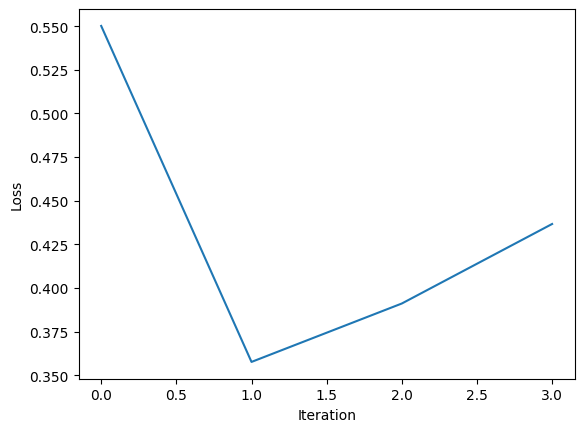

In [ ]:
plt.plot(np.arange(len(als.losses)), als.losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

## Recommendation - Unrated Items Prediction

In [ ]:
# Choose random user_id
# user_id = np.random.randint(0, als.N)
user_id = 511

# Select top 10 highest rating predictions
n_recom = 10

recommend_list = als.recommend(user_id, n_recom)

In [ ]:
print(f"User_id: {user_id}")
recommend_list.head(10)

User_id: 511


,item_id,prediction
0,1658,4.615336
1,598,4.608093
2,1620,4.595163
3,1617,4.577876
4,1501,4.561843
5,1625,4.549637
6,1485,4.549287
7,1493,4.549287
8,1492,4.549287
9,1670,4.536892


## Evaluation in Testset

In [ ]:
eval_ALS_df, rmse_ALS = als.evaluate(test_user_item_matrix)

In [ ]:
print(f"RMSE: {rmse_ALS}")
eval_ALS_df.head()

RMSE: 0.9981555881423299


,user_id,item_id,ground_truth,prediction
0,16,0,3.0,3.308118
1,46,0,4.0,3.628744
2,63,0,5.0,4.408723
3,89,0,4.0,3.203612
4,91,0,3.0,3.675644


# Compare ALS and NBCF

In [ ]:
print(f"RMSE ALS: {rmse_ALS} - RMSE NBCF: {rmse_NBCF}")

RMSE ALS: 0.9981555881423299 - RMSE NBCF: 1.4524922739631903


In [ ]:
import time

In [ ]:
def create_compressed_sparse_matrix(dataframe):
    return csr_matrix(
            (dataframe["rating"], \
            (dataframe["user_id"] - 1, dataframe["item_id"] - 1)),
            shape=(dataframe["user_id"].max() + 1,
                    dataframe["item_id"].max() + 1), dtype=np.float64)

## Fitting time on Trainset

In [ ]:
n = train_df.shape[0]
sizes = [int(0.1*n), int(0.3*n), int(0.5*n), int(0.7*n), n]
algorithms = [
    {
        "name": "NBCF",
        "class": NBCF,
        "params": {"k": 1, "dist_func": cosine_similarity, "uuCF": 1}
    },
    {
        "name": "ALS",
        "class": ALS,
        "params": {"n_factors": 6, "lambda_reg": 0.001, "print_loss": False}
    }
]

execution_time = {"NBCF": [],  "ALS": []}

for size in sizes:
    print(f"Trainset size: {size}")

    tmp_train_df = train_df.sample(size)

    user_item_matrix = create_compressed_sparse_matrix(tmp_train_df)
    for alg in algorithms:
        alg_instance = alg["class"](**alg["params"])

        start_time = time.time()
        alg_instance.fit(user_item_matrix)
        end_time = time.time()

        execution_time[alg["name"]].append(end_time - start_time)
        print(f"Algorithm: {alg['name']}, Execution time: {end_time - start_time: .4f} seconds")

    print("-"*128)

Trainset size: 9057
Algorithm: NBCF, Execution time:  0.2555 seconds
Algorithm: ALS, Execution time:  8.0415 seconds
--------------------------------------------------------------------------------------------------------------------------------
Trainset size: 27171
Algorithm: NBCF, Execution time:  0.2543 seconds
Algorithm: ALS, Execution time:  7.2381 seconds
--------------------------------------------------------------------------------------------------------------------------------
Trainset size: 45285
Algorithm: NBCF, Execution time:  0.7141 seconds
Algorithm: ALS, Execution time:  10.0303 seconds
--------------------------------------------------------------------------------------------------------------------------------
Trainset size: 63398
Algorithm: NBCF, Execution time:  0.2780 seconds
Algorithm: ALS, Execution time:  11.6037 seconds
--------------------------------------------------------------------------------------------------------------------------------
Trainset si

### Graph Fitting on Trainset

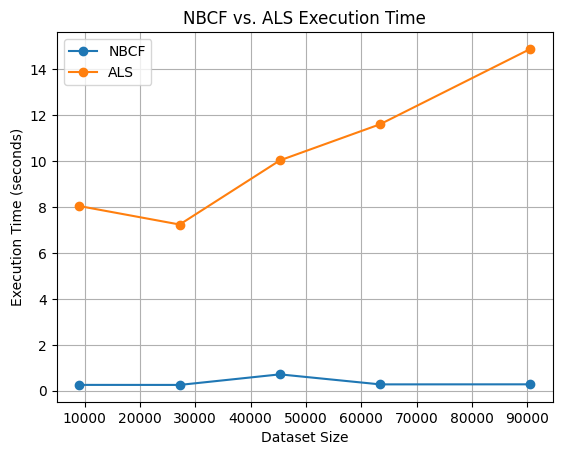

In [ ]:
plt.plot(sizes, execution_time["NBCF"], marker='o',
                                            linestyle='-', label="NBCF")
plt.plot(sizes, execution_time["ALS"], marker='o',
                                                linestyle='-', label="ALS")
plt.xlabel("Dataset Size")
plt.ylabel("Execution Time (seconds)")
plt.title("NBCF vs. ALS Execution Time")
plt.grid(True)
plt.legend()
plt.show()

## Evaluation on Testset

In [ ]:
m = test_df.shape[0]
sizes = [int(0.1*m), int(0.3*m), int(0.5*m), int(0.7*m), m]

nbcf = NBCF(k=10, uuCF=1)
nbcf.fit(train_user_item_matrix)

als = ALS(n_factors=6, lambda_reg=0.001, print_loss=False)
als.fit(train_user_item_matrix)

algorithms = [
    {
        "name": "NBCF",
        "model": nbcf
    },
    {
        "name": "ALS",
        "model": als
    }
]

rmse_s = {"NBCF": [],  "ALS": []}

for size in sizes:
    print(f"Testset size: {size}")

    tmp_test_df = train_df.sample(size)

    user_item_matrix = create_compressed_sparse_matrix(tmp_test_df)
    for alg in algorithms:
        _, rmse_value = alg["model"].evaluate(user_item_matrix)

        rmse_s[alg["name"]].append(rmse_value)
        print(f"Algorithm: {alg['name']},  RMSE: {rmse_value}")

    print("-"*128)

Testset size: 943
Algorithm: NBCF,  RMSE: 1.4180649985809328
Algorithm: ALS,  RMSE: 0.9341083984402534
--------------------------------------------------------------------------------------------------------------------------------
Testset size: 2829
Algorithm: NBCF,  RMSE: 1.400009777326297
Algorithm: ALS,  RMSE: 0.9467893926459577
--------------------------------------------------------------------------------------------------------------------------------
Testset size: 4715
Algorithm: NBCF,  RMSE: 1.3953721742424376
Algorithm: ALS,  RMSE: 0.9385812051127246
--------------------------------------------------------------------------------------------------------------------------------
Testset size: 6601
Algorithm: NBCF,  RMSE: 1.3677982883954023
Algorithm: ALS,  RMSE: 0.9465800925273558
--------------------------------------------------------------------------------------------------------------------------------
Testset size: 9430
Algorithm: NBCF,  RMSE: 1.359988091147155
Algorithm

### Graph Evaluation in Testset

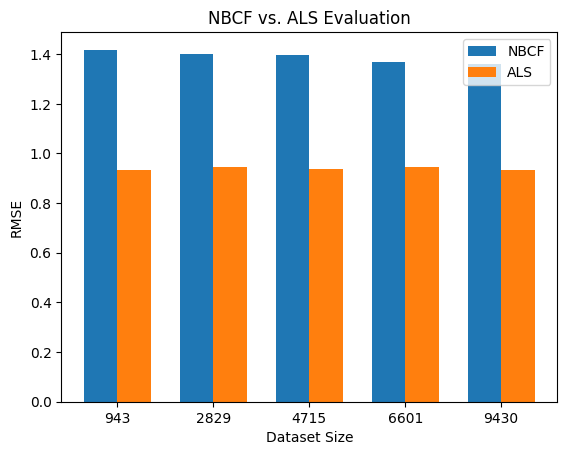

In [ ]:

# Get the RMSE values for each algorithm
rmse_nbcf = rmse_s['NBCF']
rmse_als = rmse_s['ALS']

# X-axis positions for the bars
x_pos = np.arange(len(rmse_nbcf))

# Width of the bars
bar_width = 0.35

# Create the bar chart
plt.bar(x_pos, rmse_nbcf, width=bar_width, label='NBCF', color='tab:blue')
plt.bar(x_pos + bar_width, rmse_als, width=bar_width, label='ALS', color='tab:orange')


plt.xlabel("Dataset Size")
plt.ylabel("RMSE")
plt.title("NBCF vs. ALS Evaluation")
# plt.grid(True)

plt.xticks(x_pos + bar_width / 2, sizes)  # Customize x-axis tick labels
plt.legend()
plt.show()
